##Лабораторная № 4. Обучение рекурентной нейронной сети

*Кузьмина Н.В. J4140*

Скачайте датасет с фамилиями разных национальностей, используемый на практическом
занятии. Необходимо обучить несколько рекурентных нейронных сетей для
классификации фамилий по национальностям. Нейтронные сети должны отличаться
гиперпараметрами.

In [1]:
from argparse import Namespace
import os
import json

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

####Vocabulary, Vectorizer, Dataset

In [33]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""

    def __init__(self, token_to_idx=None):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token
                              for token, idx in self._token_to_idx.items()}


    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def add_many(self, tokens):
        """Add a list of tokens into the Vocabulary

        Args:
            tokens (list): a list of string tokens
        Returns:
            indices (list): a list of indices corresponding to the tokens
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """Retrieve the index associated with the token

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index

        Args:
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [34]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def lookup_token(self, token):
        """Retrieve the index associated with the token
          or the UNK index if token isn't present.

        Args:
            token (str): the token to look up
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary)
              for the UNK functionality
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

In [35]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, char_vocab, nationality_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname, vector_length=-1):
        """
        Args:
            title (str): the string of characters
            vector_length (int): an argument for forcing the length of index vector
        """
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token)
                       for token in surname)
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.char_vocab.mask_index

        return out_vector, len(indices)

    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe

        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        char_vocab = SequenceVocabulary()
        nationality_vocab = Vocabulary()

        for index, row in surname_df.iterrows():
            for char in row.surname:
                char_vocab.add_token(char)
            nationality_vocab.add_token(row.nationality)

        return cls(char_vocab, nationality_vocab)

In [36]:
class SurnameDataset(Dataset):
    def __init__(self, surname_df, vectorizer):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
            vectorizer (SurnameVectorizer): vectorizer instatiated from dataset
        """
        self.surname_df = surname_df
        self._vectorizer = vectorizer

        self._max_seq_length = max(map(len, self.surname_df.surname)) + 2

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size)}

        self.set_split('train')

        # Class weights
        class_counts = self.train_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)


    @classmethod
    def load_dataset_and_make_vectorizer(cls, surname_csv):
        """Load dataset and make a new vectorizer from scratch

        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        train_surname_df = surname_df[surname_df.split=='train']
        return cls(surname_df, SurnameVectorizer.from_dataframe(train_surname_df))


    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets

        Args:
            index (int): the index to the data point
        Returns:
            a dictionary holding the data point's:
                features (x_data)
                label (y_target)
                feature length (x_length)
        """
        row = self._target_df.iloc[index]

        surname_vector, vec_length = \
            self._vectorizer.vectorize(row.surname, self._max_seq_length)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': surname_vector,
                'y_target': nationality_index,
                'x_length': vec_length}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size



def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

####Model

In [31]:
def column_gather(y_out, x_lengths):
    '''Get a specific vector from each batch datapoint in `y_out`.

    More precisely, iterate over batch row indices, get the vector that's at
    the position indicated by the corresponding value in `x_lengths` at the row
    index.

    Args:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, sequence, feature)
        x_lengths (torch.LongTensor, torch.cuda.LongTensor)
            shape: (batch,)

    Returns:
        y_out (torch.FloatTensor, torch.cuda.FloatTensor)
            shape: (batch, feature)
    '''
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)


class SurnameClassifier(nn.Module):
    """ A Classifier with an RNN to extract features and an MLP to classify """
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0):
        """
        Args:
            embedding_size (int): The size of the character embeddings
            num_embeddings (int): The number of characters to embed
            num_classes (int): The size of the prediction vector
                Note: the number of nationalities
            rnn_hidden_size (int): The size of the RNN's hidden state
            batch_first (bool): Informs whether the input tensors will
                have batch or the sequence on the 0th dimension
            padding_idx (int): The index for the tensor padding;
                see torch.nn.Embedding
        """
        super(SurnameClassifier, self).__init__()

        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)
        self.rnn = nn.RNN(input_size=embedding_size,
                           hidden_size=rnn_hidden_size,
                           batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                         out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        """The forward pass of the classifier

        Args:
            x_in (torch.Tensor): an input data tensor.
                x_in.shape should be (batch, input_dim)
            x_lengths (torch.Tensor): the lengths of each sequence in the batch.
                They are used to find the final vector of each sequence
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        x_embedded = self.emb(x_in)
        y_out, _ = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(y_out))
        y_out = self.fc2(y_out)
        # y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        # y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

In [32]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

####Settings

In [8]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    # Model hyper parameter
    char_embedding_size=100,
    rnn_hidden_size=64,
    # Training hyper parameter
    num_epochs=25,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


In [9]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

####Training Routine

In [10]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset,
                                        batch_size=args.batch_size,
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])

        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

####Оценка

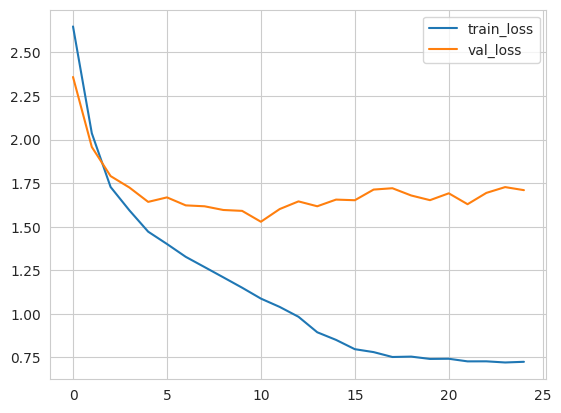

In [12]:
loss_labels = ["train_loss", "val_loss"]

for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()

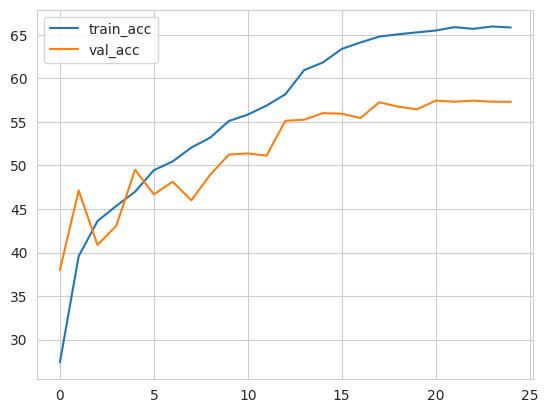

In [13]:
acc_labels = ["train_acc", "val_acc"]
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()

Существует заметный разрыв между тренировочной и валидационной точностью, который становится более заметным по мере продолжения обучения. Это может указывать на то, что модель переобучается.

###1. Проведите два эксперимента-исследования при изменении гиперпараметров, cформулируйте выводы:

• Измените архитектуру нейронной сети (например, RNN, LSTM, GRU и т.д.),
self.rnn = nn.RNN(input_size=embedding_size,
hidden_size=rnn_hidden_size,
batch_first=batch_first)


####LSTM

In [54]:
def column_gather(y_out, x_lengths):
    x_lengths = x_lengths.long().detach().cpu().numpy() - 1

    out = []
    for batch_index, column_index in enumerate(x_lengths):
        out.append(y_out[batch_index, column_index])

    return torch.stack(out)


class SurnameClassifier(nn.Module):
    def __init__(self, embedding_size, num_embeddings, num_classes,
                 rnn_hidden_size, batch_first=True, padding_idx=0):
        super(SurnameClassifier, self).__init__()

        self.emb = nn.Embedding(num_embeddings=num_embeddings,
                                embedding_dim=embedding_size,
                                padding_idx=padding_idx)
        self.rnn = nn.LSTM(input_size=embedding_size,
                           hidden_size=rnn_hidden_size,
                           batch_first=batch_first)
        self.fc1 = nn.Linear(in_features=rnn_hidden_size,
                         out_features=rnn_hidden_size)
        self.fc2 = nn.Linear(in_features=rnn_hidden_size,
                          out_features=num_classes)

    def forward(self, x_in, x_lengths=None, apply_softmax=False):
        x_embedded = self.emb(x_in)
        y_out, _ = self.rnn(x_embedded)

        if x_lengths is not None:
            y_out = column_gather(y_out, x_lengths)
        else:
            y_out = y_out[:, -1, :]

        y_out = F.relu(self.fc1(y_out))
        y_out = self.fc2(y_out)
        # y_out = F.relu(self.fc1(F.dropout(y_out, 0.5)))
        # y_out = self.fc2(F.dropout(y_out, 0.5))

        if apply_softmax:
            y_out = F.softmax(y_out, dim=1)

        return y_out

In [55]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)


In [56]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    # Model hyper parameter
    char_embedding_size=100,
    rnn_hidden_size=64,
    # Training hyper parameter
    num_epochs=25,
    learning_rate=1e-3,
    batch_size=64,
    seed=1337,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


In [57]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [58]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [59]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset,
                                        batch_size=args.batch_size,
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])

        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

  0%|          | 0/25 [00:00<?, ?it/s]

####Оценка

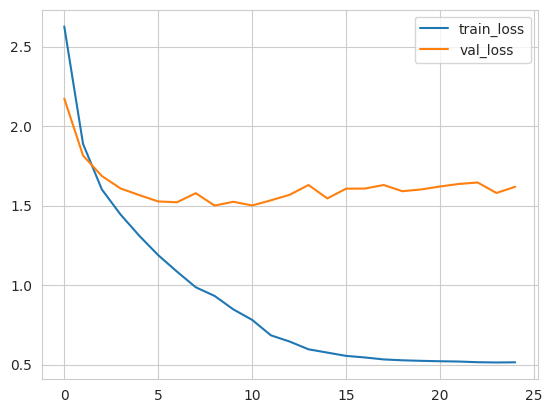

In [60]:
loss_labels = ["train_loss", "val_loss"]

for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()

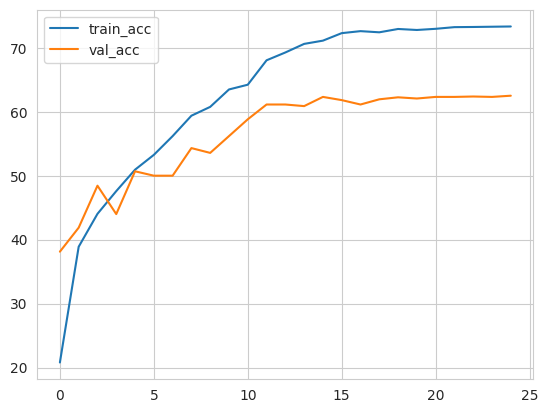

In [61]:
acc_labels = ["train_acc", "val_acc"]
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()

In [26]:
classifier.eval()

SurnameClassifier(
  (emb): Embedding(80, 100, padding_idx=0)
  (rnn): LSTM(100, 64, batch_first=True)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=18, bias=True)
)

####Выводы

* В отличие от модели RNN, валидационные потери после использования LSTM остаются стабильными и не увеличиваются с течением времени.

* Точность на тренировочных и валидационных данных стабильно увеличивается с течением времени. Разрыв между тренировочной и валидационной точностью сохраняется, но он не увеличивается, что также свидетельствует о хорошем обобщении.

* Максимальное значение точности на валидационных данных выше по сравнению с моделью RNN, что указывает на лучшее качество модели при использовании LSTM для данной задачи.

• Измените гиперпараметры для выбранной архитектуры сети (например,
embedding_size, rnn_hidden_size и др).

####Model

In [62]:
args = Namespace(
    # Data and path information
    surname_csv="surnames_with_splits.csv",
    # Model hyper parameter
    char_embedding_size=128, # Увеличение размера эмбеддинга символов
    rnn_hidden_size=128, # Увеличение размера скрытого слоя LSTM
    # Training hyper parameter
    num_epochs=25,
    learning_rate=1e-4, # Уменьшение скорости обучения
    batch_size=128, # Увеличение размера батча
    seed=1337,
    # Runtime hyper parameter
    cuda=True,
    catch_keyboard_interrupt=True,
)

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

Using CUDA: False


In [63]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [64]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [65]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset,
                                        batch_size=args.batch_size,
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])

        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

  0%|          | 0/25 [00:00<?, ?it/s]

####Оценка

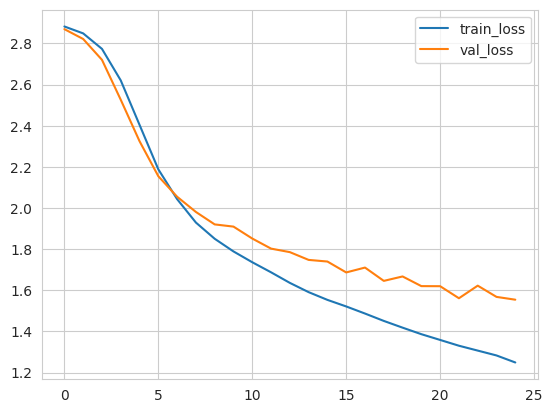

In [66]:
loss_labels = ["train_loss", "val_loss"]

for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()

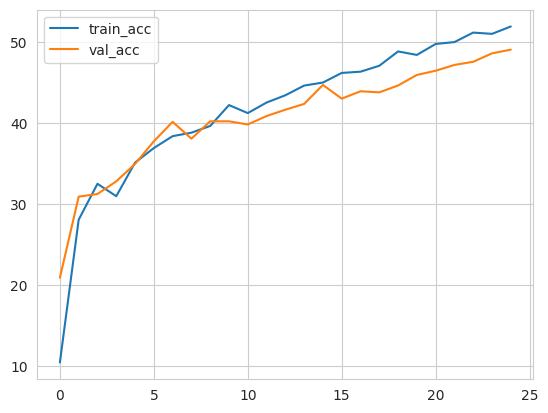

In [67]:
acc_labels = ["train_acc", "val_acc"]
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()

####Выводы

* Тренировочные потери (train_loss) стабильно уменьшаются, что указывает на эффективное обучение модели. Валидационные потери (val_loss) также снижаются, но после определённого момента начинают плавно колебаться. Колебания валидационных потерь на поздних этапах могут указывать на необходимость дальнейшей настройки гиперпараметров или применения техник регуляризации
* Точность как на обучающем, так и на валидационном наборе данных повышается со временем, что указывает на то, что модель продолжает учиться в течение всего процесса обучения.
* Кривые точности на обучающем и валидационном наборах данных близки друг к другу и следуют схожей траектории, что может свидетельствовать о хорошем балансе между способностью модели к обучению и её способностью к обобщению

###2. Выберите один из наборов гиперпараметров и проиллюстрируйте зависимость качества классификации от количества эпох обучения. Можно ли выделить эпохи,где модель недообучилась/переобучилась?

Увеличим количество эпох в прошлом эксперименте.

In [73]:
args.num_epochs = 50  # Увеличение количества эпох обучения

####Model

In [74]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [75]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [76]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset,
                                        batch_size=args.batch_size,
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])

        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

  0%|          | 0/50 [00:00<?, ?it/s]

####Оценка

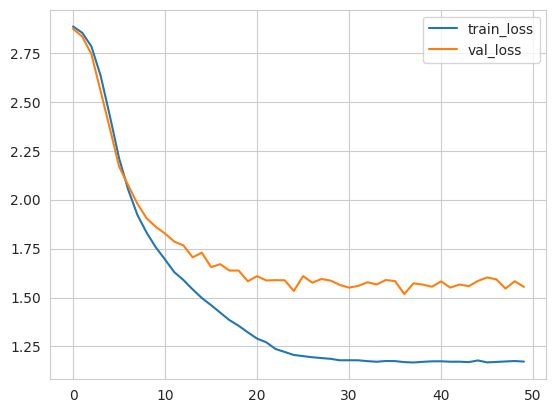

In [77]:
loss_labels = ["train_loss", "val_loss"]

for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()

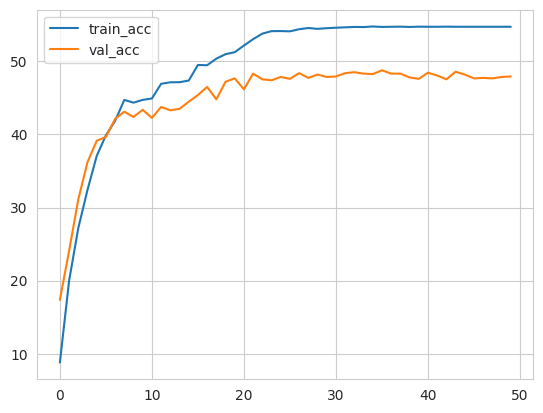

In [78]:
acc_labels = ["train_acc", "val_acc"]
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()

####Выводы

**Недообучение:**

В начальной фазе (примерно до 5-10 эпох) наблюдается быстрое снижение тренировочных потерь и быстрый рост точности. Это указывает на то, что модель ещё учится извлекать закономерности из данных.
Валидационные потери также резко уменьшаются, а валидационная точность увеличивается, что говорит о том, что модель все еще улучшает свою способность обобщать.

**Оптимальное обучение:**

После начального периода быстрого улучшения производительности, скорость уменьшения тренировочных потерь и увеличения точности замедляется. На графиках это происходит приблизительно с 10 по 25 эпоху. Это может быть периодом, когда модель достигает оптимального баланса между обучением и обобщением.

**Переобучение:**

Обычно признаки переобучения проявляются, когда тренировочные потери продолжают уменьшаться, в то время как валидационные потери начинают увеличиваться или стагнировать. Однако на полученных графиках валидационные потери продолжают постепенно снижаться вплоть до 50-й эпохи, а валидационная точность стабилизируется без значительного ухудшения.

Полученные графики не показывают явных признаков ни недообучения после начального периода, ни переобучения даже после 50 эпох обучения.

###3. Целевые метки в датасете не сбалансированы. Для учета весов классов в функцию потерь CrossEntropyLoss передают аргумент с соответствующими весами. Как изменились потери/точность при обучении при наличии/отсутствии аргумента с весами классов? Чем можно объяснить данные изменения?

dataset.class_weights = dataset.class_weights.to(args.device)

loss_func = nn.CrossEntropyLoss(dataset.class_weights)

В предыдущем пункте модель была обучена при наличии аргумента с весами классов. При отсутствии аргумента с весами классов:

####Model

In [86]:
dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
vectorizer = dataset.get_vectorizer()
classifier = SurnameClassifier(embedding_size=args.char_embedding_size,
                               num_embeddings=len(vectorizer.char_vocab),
                               num_classes=len(vectorizer.nationality_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

In [87]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [88]:
classifier = classifier.to(args.device)
dataset.class_weights = dataset.class_weights.to(args.device)

# Инициализация функции потерь без весов классов
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)

train_state = {'learning_rate': args.learning_rate,
               'epoch_index': 0,
               'train_loss': [],
               'train_acc': [],
               'val_loss': [],
               'val_acc': []}

for epoch_index in tqdm(range(args.num_epochs)):
    train_state['epoch_index'] = epoch_index

    dataset.set_split('train')
    batch_generator = generate_batches(dataset,
                                        batch_size=args.batch_size,
                                        device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])

        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        loss.backward()

        optimizer.step()
        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)

    dataset.set_split('val')
    batch_generator = generate_batches(dataset,
                                       batch_size=args.batch_size,
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    classifier.eval()

    for batch_index, batch_dict in enumerate(batch_generator):
        y_pred = classifier(x_in=batch_dict['x_data'],
                            x_lengths=batch_dict['x_length'])

        loss = loss_func(y_pred, batch_dict['y_target'])
        running_loss += (loss.item() - running_loss) / (batch_index + 1)

        acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
        running_acc += (acc_t - running_acc) / (batch_index + 1)

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)

    scheduler.step(train_state['val_loss'][-1])

  0%|          | 0/50 [00:00<?, ?it/s]

####Оценка

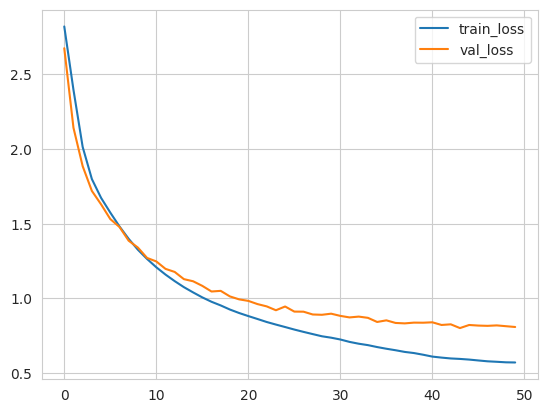

In [89]:
loss_labels = ["train_loss", "val_loss"]

for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()

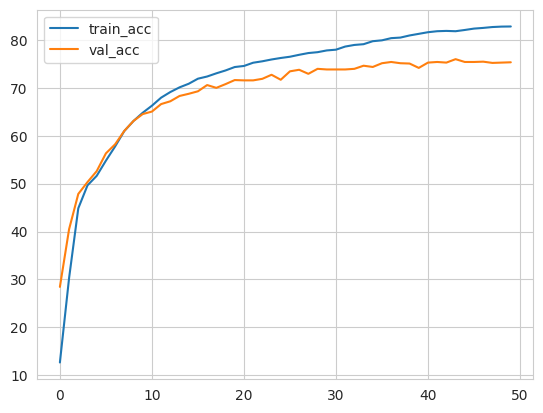

In [90]:
acc_labels = ["train_acc", "val_acc"]
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()

####Выводы

 * На графиках потерь, где использовались веса классов, валидационные потери показывают меньшую тенденцию к уменьшению со временем по сравнению с тренировочными потерями, что может указывать на лучшее обобщение.
 * Без весов классов видно более плотное сближение тренировочных и валидационных потерь, что может говорить о том, что модель лучше оптимизируется под общие характеристики данных.
 * В обоих случаях (с весами и без) валидационная точность увеличивается со временем и выравнивается на определенном уровне.
 * В обоих случаях (с весами и без) валидационная точность увеличивается со временем и выравнивается на определенном уровне. Однако на графике без весов классов тренировочная и валидационная точность ближе друг к другу, что может свидетельствовать о более сбалансированной производительности по всем классам.

###4. Какие национальности определяются лучше всего? С чем это может быть связано? Можно ли выделить группы национальностей в которых алгоритм путается больше всего? С чем это может быть связано? Визуализируйте результаты (например, с использованием confusion matrix).

In [92]:
def predict_nationality(surname, classifier, vectorizer):
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)

    result = classifier(vectorized_surname, vec_length, apply_softmax=True)
    probability_values, indices = result.max(dim=1)

    index = indices.item()
    prob_value = probability_values.item()

    predicted_nationality = vectorizer.nationality_vocab.lookup_index(index)

    return f"{surname} - {predicted_nationality} ({round(prob_value, 2)})"

In [97]:
predict_nationality('Kuzmina', classifier, vectorizer)

'Kuzmina - Russian (0.43)'

In [100]:
predict_nationality('Severiukhina', classifier, vectorizer)

'Severiukhina - Russian (0.87)'

In [102]:
df = pd.read_csv('surnames_with_splits.csv')

In [104]:
# Загрузка тестовых данных
test_df = df[df.split =="test"].reset_index(drop=True)

In [105]:
def predict_nationality(surname, classifier, vectorizer):
    vectorized_surname, vec_length = vectorizer.vectorize(surname)
    vectorized_surname = torch.tensor(vectorized_surname).unsqueeze(dim=0)
    vec_length = torch.tensor([vec_length], dtype=torch.int64)

    result = classifier(vectorized_surname, vec_length, apply_softmax=True)
    probability_values, indices = result.max(dim=1)

    prob_value = probability_values.item()
    predicted_index = indices.item()

    return predicted_index, prob_value

In [106]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [107]:
true_nationalities = test_df['nationality'].tolist()
predicted_nationalities = []

In [109]:
for surname in test_df['surname']:
  predicted_index, _ = predict_nationality(surname, classifier, vectorizer)
  predicted_nationalities.append(vectorizer.nationality_vocab.lookup_index(predicted_index))

In [115]:
nationality_index = {nationality: i for i, nationality in enumerate(vectorizer.nationality_vocab._token_to_idx)}

In [116]:
true_indices = [nationality_index[nat] for nat in true_nationalities]
predicted_indices = [nationality_index[nat] for nat in predicted_nationalities]

In [117]:
conf_matrix = confusion_matrix(true_indices, predicted_indices, labels=range(len(nationality_index)))

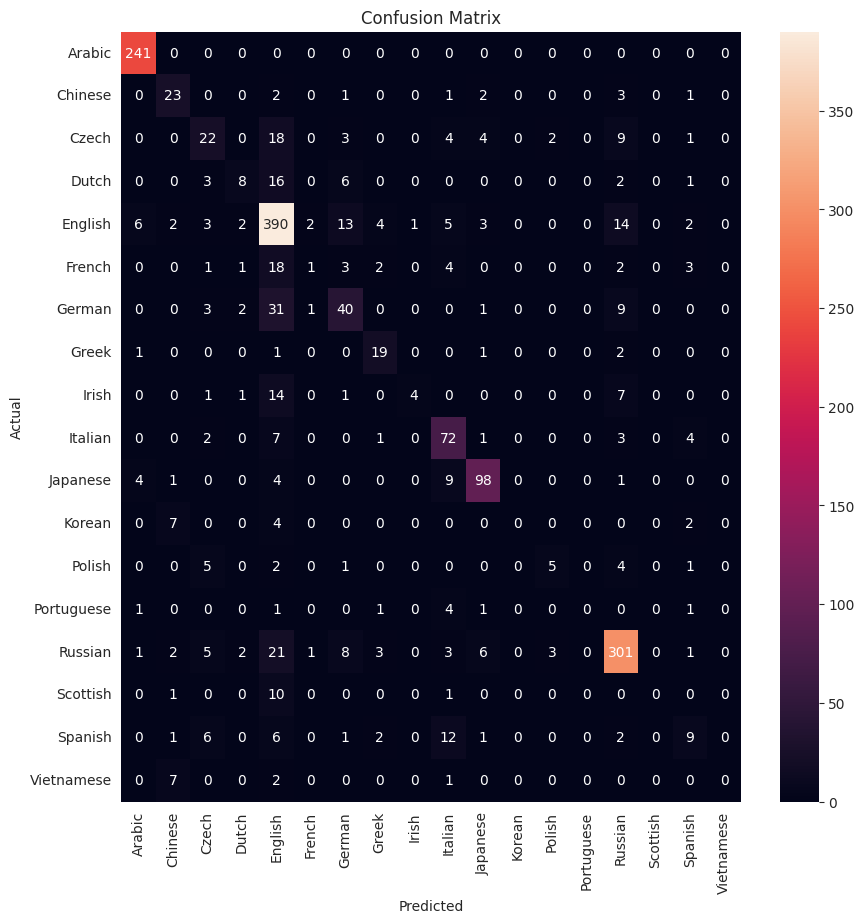

In [121]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=vectorizer.nationality_vocab._idx_to_token.values(), yticklabels=vectorizer.nationality_vocab._idx_to_token.values(), ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Национальности, для которых модель работает лучше всего, могут быть определены по самым тёмным ячейкам на диагонали. Например, 'Arabic', 'English', 'Italian', 'Japanese' и 'Russian' имеют высокие значения по диагонали, что означает, что модель правильно классифицировала большинство фамилий этих национальностей.
Это может быть связано с уникальными особенностями фамилий данных национальностей, которые легко отличимы от других, или с тем, что данные национальности были лучше представлены в обучающем наборе данных.

Группы национальностей, в которых алгоритм чаще всего путается, можно идентифицировать, обратив внимание на ячейки вне диагонали, которые имеют относительно высокие значения. Например, 'English' часто путается с 'German', 'Czech', 'Dutch', 'Russian', 'Scottish'. 'Italian' путается с 'Spanish'.
Такая путаница может быть связана с лингвистической близостью или схожестью фамилий разных национальностей, историческими или культурными перекрестными влияниями, которые делают фамилии похожими между этими национальностями.